## Semantic text search using Azure OpenAI embeddings

We can search through all our reviews semantically in a very efficient manner and at very low cost, by simply embedding our search query, and then finding the most similar reviews. 

In [1]:
import os
import sys
os.path.dirname(sys.executable)


'c:\\Python\\Python311'

In [2]:
import os
import sys
os.path.dirname(sys.executable)


'C:\\Users\\rolester\\AppData\\Local\\Microsoft\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0'

In [2]:
#pip install openai num2words matplotlib plotly scipy scikit-learn transformers
#!pip install --upgrade openai
#!pip install --upgrade NumPy==1.24.0
#!pip install --upgrade numpy==1.22.4
#!pip install --upgrade numpy



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\rolester\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import os
import openai
import pandas as pd
import numpy as np
import re
import requests
import sys
from openai.embeddings_utils import get_embedding, cosine_similarity


In [49]:
import os
import openai
from dotenv import load_dotenv

# Set up Azure OpenAI
load_dotenv("credentials.env")

openai.api_type = "azure"
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT") # Api base is the 'Endpoint' which can be found in Azure Portal where Azure OpenAI is created. It looks like https://xxxxxx.openai.azure.com/
openai.api_version ="2023-03-15-preview"
openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")

In [50]:
print(openai.api_key)

9ed9191bbdae445cbe69af2709668995


In [51]:
openai.Model.list()

<OpenAIObject list at 0x7fb2fabe9260> JSON: {
  "data": [
    {
      "capabilities": {
        "fine_tune": false,
        "inference": false,
        "completion": true,
        "chat_completion": false,
        "embeddings": false,
        "scale_types": [
          "manual"
        ]
      },
      "lifecycle_status": "preview",
      "deprecation": {
        "fine_tune": 1720137600,
        "inference": 1720137600
      },
      "id": "ada",
      "status": "succeeded",
      "created_at": 1646092800,
      "updated_at": 1688601600,
      "object": "model"
    },
    {
      "capabilities": {
        "fine_tune": false,
        "inference": false,
        "completion": true,
        "chat_completion": false,
        "embeddings": false,
        "scale_types": [
          "manual"
        ]
      },
      "lifecycle_status": "preview",
      "deprecation": {
        "fine_tune": 1720137600,
        "inference": 1720137600
      },
      "id": "babbage",
      "status": "succeeded",

In [55]:
openai.api_resources.Deployment.list()

<OpenAIObject list at 0x7fb2fab0da30> JSON: {
  "data": [
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "code-davinci-002",
      "owner": "organization-owner",
      "id": "sascodeconversion",
      "status": "succeeded",
      "created_at": 1680508520,
      "updated_at": 1680508520,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "gpt-35-turbo",
      "owner": "organization-owner",
      "id": "gpt35yk",
      "status": "succeeded",
      "created_at": 1680531760,
      "updated_at": 1688404070,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "gpt-4",
      "owner": "organization-owner",
      "id": "gpt4test",
      "status": "succeeded",
      "created_at": 1681205528,
      "updated_at": 1681205528,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type"

In [54]:
# list models deployed with embeddings capability
deployment_id = None
result = openai.Deployment.list()

for deployment in result.data:
    if deployment["status"] != "succeeded":
        continue
    
    model = openai.Model.retrieve(deployment["model"])
    if model["capabilities"]["embeddings"] != True:
        continue
    
    deployment_id = deployment["id"]
    break

# if not model deployed, deploy one
if not deployment_id:
    print('No deployment with status: succeeded found.')
    model = "text-similarity-davinci-001"

    # Now let's create the deployment
    print(f'Creating a new deployment with model: {model}')
    result = openai.Deployment.create(model=model, scale_settings={"scale_type":"standard"})
    deployment_id = result["id"]
    print(f'Successfully created {model} with deployment_id {deployment_id}')
else:
    print(f'Found a succeeded deployment that supports embeddings with id: {deployment_id}.')

Found a succeeded deployment that supports embeddings with id: text-embedding-ada-002.


In [3]:
# Function to read paragraphs from the text file
def read_paragraphs(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        paragraphs = content.split('\n\n')
    return paragraphs

file_path = './Alice.txt' #27,000 words
paragraphs = read_paragraphs(file_path)

paragraphs_df = pd.DataFrame({'paragraph': paragraphs})

paragraphs_df['paragraph'].count()


827

In [4]:
paragraphs_df = paragraphs_df[paragraphs_df["paragraph"] != ''] #Remove black strings

In [5]:
paragraphs_df['embedding'] = paragraphs_df["paragraph"].apply(lambda x : get_embedding(x, engine = "text-embedding-ada-002"))
#4 mins v1
#3 mins v2

#https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/integrate-synapseml


In [6]:
paragraphs_df.head()

,paragraph,embedding
0,CHAPTER I. Down the Rabbit-Hole,"[-0.0009895042749121785, -0.003143131267279386..."
1,Alice was beginning to get very tired of sitti...,"[-0.005550594534724951, -0.002100438578054309,..."
2,So she was considering in her own mind (as wel...,"[-0.016373122110962868, -0.00787348672747612, ..."
3,There was nothing so VERY remarkable in that; ...,"[-0.013116865418851376, -0.009315624833106995,..."
4,"In another moment down went Alice after it, ne...","[0.0011981818825006485, -0.009525999426841736,..."


In [7]:
paragraphs_df['embedding'][0]

[-0.0009895042749121785,
 -0.0031431312672793865,
 -0.009399459697306156,
 -0.006512435153126717,
 -0.018000662326812744,
 0.00574744027107954,
 -0.008222032338380814,
 -0.02956206351518631,
 -0.01226652693003416,
 -0.00888059288263321,
 -0.0006294577615335584,
 0.0007807937217876315,
 -0.024253664538264275,
 -0.00713773537427187,
 0.008328466676175594,
 -0.01475442387163639,
 0.017388667911291122,
 -0.0011491554323583841,
 0.0022334526292979717,
 -0.005943677853792906,
 -0.010211018845438957,
 0.01511363871395588,
 -0.0051454221829771996,
 -0.03004101850092411,
 -0.018027272075414658,
 -0.012007093988358974,
 0.01268561091274023,
 -0.03238256648182869,
 0.013570345006883144,
 0.0036121064331382513,
 -0.0003022561431862414,
 0.006951475515961647,
 -0.01595180667936802,
 -0.027513207867741585,
 -0.006342805456370115,
 -0.003073283936828375,
 -0.005574484821408987,
 -0.001747847069054842,
 0.0003727271396201104,
 -0.00808233767747879,
 0.019703608006238937,
 0.014488338492810726,
 -0.011

### Normalize text ###

### Calculate embedding for review summary and review text and save it to local file ###

In [8]:
paragraphs_df.to_csv('data/Alice_with_embeddings.csv')

### Load pre-calculated embedding from file ###

In [24]:
datafile_path = "data/Alice_with_embeddings.csv"
df = pd.read_csv(datafile_path)
df["embedding"] = df.embedding.apply(eval).apply(np.array)
df.head(5)

,Unnamed: 0,paragraph,embedding
0,0,CHAPTER I. Down the Rabbit-Hole,"[-0.0009895042749121785, -0.003143131267279386..."
1,1,Alice was beginning to get very tired of sitti...,"[-0.005550594534724951, -0.002100438578054309,..."
2,2,So she was considering in her own mind (as wel...,"[-0.016373122110962868, -0.00787348672747612, ..."
3,3,There was nothing so VERY remarkable in that; ...,"[-0.013116865418851376, -0.009315624833106995,..."
4,4,"In another moment down went Alice after it, ne...","[0.0011981818825006485, -0.009525999426841736,..."


### Function to compare the cosine similarity of the query and reviews and show top_n best matches. ###

In [27]:

# search through the reviews for a specific product using natural language text
def search_reviews(df, query, n=3, pprint=True):
    
    query_embedding = get_embedding(query,engine="text-embedding-ada-002")
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, query_embedding)) #not a call to the webservice

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .paragraph.str.replace("Summary: ", "")
        .str.replace("; Text:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:600])
            print()
    return results


In [28]:
results = search_reviews(df, "I like the red queen and cats?", n=4)

'How do you like the Queen?' said the Cat in a low voice.

'A cat may look at a king,' said Alice. 'I've read that in some book,
but I don't remember where.'

Alice replied eagerly, for she was always ready to talk about her pet:
'Dinah's our cat. And she's such a capital one for catching mice you
can't think! And oh, I wish you could see her after the birds! Why,
she'll eat a little bird as soon as look at it!'

'Call it what you like,' said the Cat. 'Do you play croquet with the
Queen to-day?'



In [31]:
results = search_reviews(df, "Is the cat nice?", n=3)

The Cat only grinned when it saw Alice. It looked good-natured, she
thought: still it had VERY long claws and a great many teeth, so she
felt that it ought to be treated with respect.

'How do you like the Queen?' said the Cat in a low voice.

'How are you getting on?' said the Cat, as soon as there was mouth
enough for it to speak with.



In [11]:
strPrompt = """The Cat only grinned when it saw Alice. It looked good-natured, she
thought: still it had VERY long claws and a great many teeth, so she
felt that it ought to be treated with respect.

'How do you like the Queen?' said the Cat in a low voice.

'How are you getting on?' said the Cat, as soon as there was mouth
enough for it to speak with.

Is the cat nice?

Dont make anythign up.

Only use the data

"""
response = openai.Completion.create(
    engine="textdavinci003yk",
    prompt=strPrompt,
    temperature=0.2, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=600,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

It is difficult to say if the cat is nice or not based on the given data. The cat is described as looking good-natured and Alice felt that it should be treated with respect. The cat also has long claws and many teeth, which could be interpreted as a sign of aggression.


In [29]:
results = search_reviews(df, "Is the red queen a bad person?", n=1)

Alice thought she might as well go back, and see how the game was going
on, as she heard the Queen's voice in the distance, screaming with
passion. She had already heard her sentence three of the players to be
executed for having missed their turns, and she did not like the look
of things at all, as the game was in such confusion that she never knew
whether it was her turn or not. So she went in search of her hedgehog.



In [14]:
strPrompt = """Alice thought she might as well go back, and see how the game was going
on, as she heard the Queen's voice in the distance, screaming with
passion. She had already heard her sentence three of the players to be
executed for having missed their turns, and she did not like the look
of things at all, as the game was in such confusion that she never knew
whether it was her turn or not. So she went in search of her hedgehog.

Is the red queen a bad person?
"""
response = openai.Completion.create(
    engine="textdavinci003yk",
    prompt=strPrompt,
    temperature=0.2, #temperatue 0-1: 0 same answers 1 different answers 
    max_tokens=600,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
#  top_p=1.0,

text = response['choices'][0]['text'].replace(' .', '.').strip()
print(text)

It depends on how you define "bad." The Queen is certainly ruthless and willing to punish those who disobey her, but she also has a strong sense of justice and fairness. Ultimately, it is up to the reader to decide whether the Queen is good or bad.


### Visualize embeddings

Load Data and Explore

In [30]:
import pandas as pd

df_orig = pd.read_csv("data/bbc-news-data.csv", delimiter='\t')
df = df_orig.copy()
df

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [56]:
embedding = openai.Embedding.create(
    input="Your text goes here",
    deployment_id=deployment_id)

# Access embeddings
len(embedding["data"][0]["embedding"])

1536

**Create Embeddings**

In [57]:
#df['embedding'] = ''

#for i in range(len(df)):    
#    try:
#        embedding = openai.Embedding.create(input=df['content'][i], deployment_id=deployment_id) #text-embedding-ada-002
#        df['embedding'][i] = embedding['data'][0]['embedding']
#    except Exception as err:
#        i
#        print(f"Unexpected {err=}, {type(err)=}")

In [58]:
#df.head()

,category,filename,title,content,embedding
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.021155867725610733, -0.01682022027671337, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[-0.02455304190516472, -0.012937315739691257, ..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.021608199924230576, -0.036890752613544464,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[-0.02186358906328678, -0.016681300476193428, ..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.008347506634891033, -0.008401579223573208,..."


In [59]:
# Save embeddings
#df.to_csv("data/bbc-news-data-embedding.csv", sep='\t', index=False)

In [60]:
import pandas as pd

df_orig = pd.read_csv("data/bbc-news-data-embedding.csv", delimiter='\t', index_col=False)

In [61]:
df = df_orig.copy()
df

,category,filename,title,content,embedding
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.021155867725610733, -0.01682022027671337, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[-0.02455304190516472, -0.012937315739691257, ..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.021608199924230576, -0.036890752613544464,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[-0.02186358906328678, -0.016681300476193428, ..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.008347506634891033, -0.008401579223573208,..."
...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,"[-0.022007180377840996, -0.009663669392466545,..."
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,"[-0.005723385605961084, -0.0186212919652462, -..."
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,"[0.0019429635722190142, -0.013848277740180492,..."
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,"[-0.00036830714088864625, -0.02817297354340553..."


In [78]:
# drop rows with NaN
df.isnull().any().any()

False

In [77]:
import numpy as np

# convert string to array
df["embedding"] = df['embedding'].apply(eval).apply(np.array)  

ValueError: source code string cannot contain null bytes

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vis_dims_pca = pca.fit_transform(df['embedding'].to_list())
vis_dims_pca.shape
vis_dims_pca

array([[ 0.21709122, -0.120118  ,  0.09731869],
       [ 0.1686701 ,  0.00195046,  0.23552517],
       [ 0.05765796, -0.05116518,  0.14049901],
       ...,
       [ 0.11798007,  0.05885415, -0.08006985],
       [ 0.07483123, -0.00526219, -0.02513973],
       [ 0.08152384, -0.04364572, -0.09394488]])

In [80]:
df["vis_dims_pca"] = vis_dims_pca.tolist()
df

,category,filename,title,content,embedding,vis_dims_pca
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.021155867725610733, -0.01682022027671337, ...","[0.21709122048111695, -0.12011800293453401, 0...."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[-0.02455304190516472, -0.012937315739691257, ...","[0.16867010316199843, 0.001950455896118721, 0...."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.021608199924230576, -0.036890752613544464,...","[0.05765795868430102, -0.051165178526531234, 0..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[-0.02186358906328678, -0.016681300476193428, ...","[0.1376211777534062, -0.007792149002785543, 0...."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.008347506634891033, -0.008401579223573208,...","[0.06838580125272653, -0.07958546412943096, 0...."
...,...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,"[-0.022007180377840996, -0.009663669392466545,...","[0.17584838933170543, 0.042669940335730495, -0..."
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,"[-0.005723385605961084, -0.0186212919652462, -...","[0.224861279654165, -0.025576173496753646, -0...."
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,"[0.0019429635722190142, -0.013848277740180492,...","[0.11798006800228619, 0.05885414564861578, -0...."
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,"[-0.00036830714088864625, -0.02817297354340553...","[0.07483123450040578, -0.005262190395875012, -..."


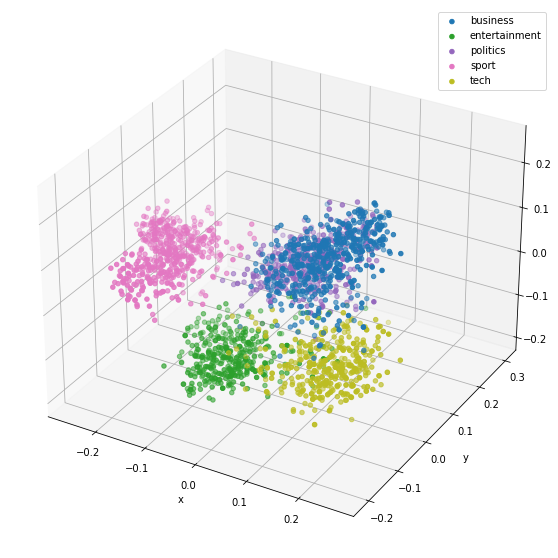

In [88]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

categories = sorted(df['category'].unique())

# Plot each sample category individually
for i, cat in enumerate(categories):
    sub_matrix = np.array(df[df["category"] == cat]["vis_dims_pca"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    _ = ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

_ = ax.set_xlabel('x')
_ = ax.set_ylabel('y')
_ = ax.set_zlabel('z')
_ = ax.legend()

## Semantic Search ##

Find Articles with Similar Embeddings to that of the Question

In [89]:
import numpy as np

def get_embedding(text, deployment_id=deployment_id):
    """ 
    Get embeddings for an input text from the dataframe. 
    """
    result = openai.Embedding.create(
      deployment_id=deployment_id,
      input=text
    )
    result = np.array(result["data"][0]["embedding"])
    return result

def vector_similarity(x, y):
    """
    Returns the similarity between two vectors.    
    Because OpenAI Embeddings are normalized to length 1, the cosine similarity is the same as the dot product.
    """
    similarity = np.dot(x, y)
    return similarity 

def order_document_sections_by_query_similarity(query, contexts):
    """
    Find the query embedding for the supplied query, and compare it against all of the pre-calculated articles embeddings
    to find the most relevant articles. 
    Return the list of articles, sorted by relevance in descending order.
    """
    query_embedding = get_embedding(query)

    document_similarities = sorted(
        [(vector_similarity(query_embedding, doc_embedding), doc_index) for doc_index, doc_embedding in contexts.items()], 
        reverse=True)
    
    return document_similarities

Retrieve Relevant Articles

In [90]:
def retrieve_relevant_documents(query, contexts = df['embedding']):
    # find text most similar to the query
    answers = order_document_sections_by_query_similarity(query=query, contexts=contexts)[0:3] # Set to top 3

    # print top 3
    for answer in answers:
        print(f'similarity score:   {answer[0]}')
        print(df['content'].loc[answer[1]], '\n')

    return

Query Examples

In [91]:
query = 'News about stock market.'
retrieve_relevant_documents(query=query)

similarity score:   0.8318361062372656
 The US stock market has closed higher in response to George W Bush's victory in the presidential elections.  The benchmark Dow Jones share index closed more than 1% higher at 10,137, while the Nasdaq rose 0.9% to 2,004. Many investors believe that Mr Bush's policies are more business-friendly than those of his Democrat challenger, John Kerry. The higher share prices also reflect relief that a clear winner has emerged from what proved to be a tight poll.  Investors had worried that the outcome of the poll would be inconclusive, paving the way for a repeat of the legal wrangling that marred the 2000 election.  The Dow lost 5% of its value in the three weeks immediately after that election, when it was unclear who would occupy the White House. Mr Kerry conceded defeat on Wednesday, abandoning last-ditch hopes of carrying the vote in the swing state of Ohio. "The relief for the markets may be that we have a decision and can move forward," said Tim Gh